# Frozen lake : Reinforcement Learning
![ Frozen lake](images/frozen_lake.gif) 

For the first part of the project we will tackle the frozen lake Envirement which involves crossing a frozen lake from the start position to a predetermined goal without falling into any holes. The solution isn't deterministic as the player can slip on the ice.
 
## Envirement description : 

### 1. Action Space
The action shape is as follows : 
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### 2. Observation Space
The observation is a value representing the player’s current position= and it ranges from 0 to the map's width*height-1.

### 3. Starting State
The episode starts with the player in state [0] at the location [0, 0] in the map.

### 4. Rewards : 
Reward can be defined as follows : 
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### 5. Episode End : 
The episode ends if the following happens:
- Termination:
    - The player moves into a hole.
    - The player reaches the goal at max(width) * max(height) - 1 (location [width-1, height-1]).
- Truncation :
    - The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.


Uploading the necessary libraries and modules needed for our experiment.

In [209]:
import gymnasium as gym
import pygame
import sys
import argparse
#from tools.qlearning import *
import numpy as np
import matplotlib.pyplot   as plt

In [296]:
# To speed up the process we will set the render_mode as None.
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode=None)
np.random.seed(42)
observation, info = env.reset(seed=42)
num_actions = env.action_space.n
num_states = env.observation_space.n

## 1. Q-Learning
### 1.1 Q-Learning

In [260]:
import numpy as np
from tqdm import *
def q_train(env, alpha=0.99, gamma=0.9, max_n_steps=100, n_episodes=100000, weights="data/q_table.npy"):
    """ Q-learning algorithm 
    
    """
    rewards =[]
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, truncated , info = env.step(a) # Take action a and observe the reward and next state s_new and reward r
            #print(s, a, r, s_new, done)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s = s_new
            total_reward = total_reward + r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))

    return q_table



In [261]:
q_table = q_train(env, weights="q_table.npy")
np.save('q_table.npy', q_table)

Loading Q-table saved weights...
Starting Q-learning algorithm...


100%|██████████| 100000/100000 [00:52<00:00, 1901.81it/s]

Finished Q-learning algorithm.
Average reward is : 0.0


### 1.1 Q-Learning ( $\epsilon-greedy$)

$\epsilon-greedy$ is an good strategy for balancing exploration and exploitation.

In [245]:
def q_train_greedy(env, alpha=0.8, gamma=0.95, epsilon=0.05, max_n_steps=100, n_episodes=100000, weights="data/q_table.npy"):
    """ Q-learning algorithm (epsilon-greedy)
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []

    print("Starting Q-learning algorithm...")
    for _ in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)
            
            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                rewards.append(total_reward) 
                break
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [283]:
q_table_greedy = q_train_greedy(env,weights="data/q_table_greedy.npy")
np.save('data/q_table_greedy.npy', q_table_greedy)

Loading Q-table saved weights...
Starting Q-learning algorithm...


100%|██████████| 100000/100000 [01:32<00:00, 1086.48it/s]

Finished Q-learning algorithm.
Average reward is : 0.26959761851724345



### 1.3 Q-learning epsilon decay
The concept of decay : 
During the lifecycle of an agent that does not have sufficient information on its environment, exploration is more important than exploitation. Once the agent has enough information about the environment, we can then start to exploit that information to improve the agent's performance [Source](https://arxiv.org/pdf/1910.13701.pdf). That's why we'll use the concept of decay by starting with a maximum value of epsilon and then decaying it gradually across every episode. 



In [285]:

def q_train_greedy_decay(env, alpha=0.8, gamma=0.9,min_epsilon=0.005, decay_rate=0.001, max_n_steps=100, n_episodes=100000, weights=None):
    """ Q-learning algorithm (epsilon-greedy) with exponential epsilon decay
    
    """
    num_actions = env.action_space.n
    num_states = env.observation_space.n
    
    try :
        print("Loading Q-table saved weights...")
        q_table = np.load(weights)

    except :
        print("Error loading Q-table saved weights")
        print("Initiating new Q-table...")
        q_table = np.zeros((num_states, num_actions))

    rewards = []
    epsilon = 1
    
    print("Starting Q-learning algorithm...")
    for episode in trange(n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_n_steps):
            U = np.random.uniform(0, 1)
            if U < epsilon:
                a = env.action_space.sample() # selecting action a at random from A 
            else:
                a = np.argmax(q_table[s]) # Select action a given s (state) following policy derived from q;
            
            s_new, r, done, _ , _= env.step(a)

            # Update Q-table
            q_table[s, a] = (1-alpha)*q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new]))
            
            # update state and total reward
            s, total_reward = s_new, total_reward+r

            # if s is a terminal state then go to next episode;
            if done: 
                # Epsilon exponential decay
                epsilon = min_epsilon + (1-min_epsilon)*np.exp(-decay_rate*episode)
                rewards.append(total_reward) 
                break
            
    env.close()
    print("Finished Q-learning algorithm.")
    print("Average reward is : {}".format(np.mean(rewards)))
    return q_table

In [287]:
q_table_greedy_decay=q_train_greedy_decay(env, weights="data/q_table_greedy_decay.npy")
np.save("data/q_table_greedy_decay.npy", q_table_greedy)

Loading Q-table saved weights...
Starting Q-learning algorithm...


100%|██████████| 100000/100000 [02:02<00:00, 816.53it/s]

Finished Q-learning algorithm.
Average reward is : 0.5132658084653978


Q_table compraisons

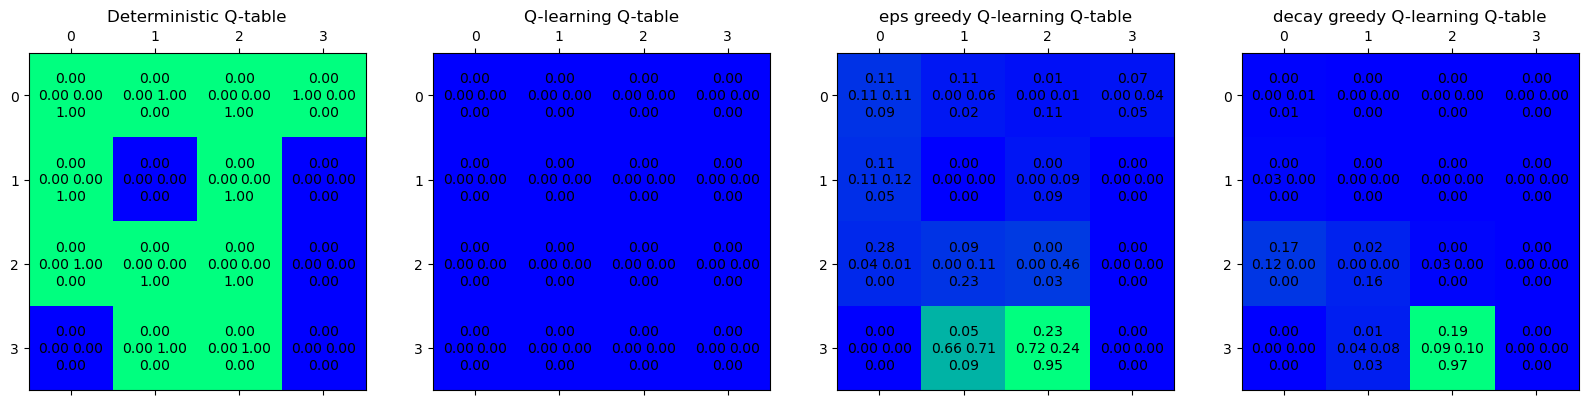

In [309]:

deterministic_q_table = np.load("data/deterministic_q_table.npy")

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5)
im = Image.open('images/frozen_lake.jpg')
plt.title("Q-table of the game")

# Creating the heat maps
map_q = np.sum(q_table, axis = 1)
map_q= map_q.reshape(4, 4)
map_d = np.sum(deterministic_q_table, axis = 1)
map_d= map_d.reshape(4, 4)
map_g = np.sum(q_table_greedy, axis = 1)
map_g= map_g.reshape(4, 4)
map_e = np.sum(q_table_greedy_decay, axis = 1)
map_e= map_e.reshape(4, 4)

ax[0].imshow(im, alpha=1)
ax[1].imshow(im, alpha=1)

ax[0].matshow(map_d, cmap='winter')
ax[1].matshow(map_q, cmap='winter')
ax[2].matshow(map_g, cmap='winter')
ax[3].matshow(map_e, cmap='winter')

pos=[0,1,2,3]

deterministic_q_table_reshaped=deterministic_q_table.reshape((4,4,4))
q_table_reshaped=q_table.reshape((4,4,4))
greedy_reshaped=q_table_greedy.reshape((4,4,4))
q_table_greedy_decay_reshaped =q_table_greedy_decay.reshape((4,4,4))
deviation = 0.2
for i in pos: # rows
    for j in pos: # cols

        ax[0].text(j-deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[0].text(j, i+deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[0].text(j+deviation, i, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[0].text(j, i-deviation, '{:0.2f}'.format(deterministic_q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[0].set_title("Deterministic Q-table")

        ax[1].text(j-deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[1].text(j, i+deviation, '{:0.2f}'.format(q_table_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[1].text(j+deviation, i, '{:0.2f}'.format(q_table_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[1].text(j, i-deviation, '{:0.2f}'.format(q_table_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[1].set_title("Q-learning Q-table")

        ax[2].text(j-deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[2].text(j, i+deviation, '{:0.2f}'.format(greedy_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[2].text(j+deviation, i, '{:0.2f}'.format(greedy_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[2].text(j, i-deviation, '{:0.2f}'.format(greedy_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[2].set_title("eps greedy Q-learning Q-table")


        ax[3].text(j-deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][0]), ha='center', va='center') # 0 Left
        ax[3].text(j, i+deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][1]), ha='center', va='center') # 1 Down
        ax[3].text(j+deviation, i, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][2]), ha='center', va='center') # 2 right
        ax[3].text(j, i-deviation, '{:0.2f}'.format(q_table_greedy_decay_reshaped[i][j][3]), ha='center', va='center') # 3 up
        ax[3].set_title("decay greedy Q-learning Q-table")

plt.show()

Then we'll define a play function for our game to test the performance

In [298]:
def agent_play(env,q_table, max_n_episodes=100000, max_steps=100):
    count = 0
    rewards = []
    num_steps = []
    for _ in trange(max_n_episodes):
        s = env.reset()[0]
        total_reward = 0
        for i in range(max_steps):
            a = np.argmax(q_table[s])
            s, r, done, _,_ = env.step(a)
            total_reward+=r
            if done: 
                rewards.append(total_reward)
                num_steps.append(i+1)
                count+=1
                break
    success_rate = np.mean(rewards)
    avg_num_steps = np.mean(num_steps)
    print(f'Success rate is = {100*success_rate} %')
    print(f'Average number of steps to succeed is = {avg_num_steps}')
    return rewards, success_rate, avg_num_steps

In [299]:
rewards_d, success_rate_d, avg_num_steps_d= agent_play(env, q_table=deterministic_q_table)

100%|██████████| 100000/100000 [00:09<00:00, 10666.47it/s]

Success rate is = 4.553999999999999 %
Average number of steps to succeed is = 5.08055


In [300]:
rewards_q, success_rate_q, avg_num_steps_q= agent_play(env, q_table=q_table)

100%|██████████| 100000/100000 [00:26<00:00, 3831.75it/s]

Success rate is = 0.0 %
Average number of steps to succeed is = 17.898731388863858


In [301]:
rewards_q_greedy, success_rate_q_greedy, avg_num_steps_q_greedy= agent_play(env, q_table=q_table_greedy)

100%|██████████| 100000/100000 [00:55<00:00, 1806.74it/s]

Success rate is = 16.18005613948819 %
Average number of steps to succeed is = 29.82702276312824


In [302]:
rewards_q_greedy_decay, success_rate_q_greedy_decay, avg_num_steps_q_greedy_decay= agent_play(env, q_table=q_table_greedy_decay)

100%|██████████| 100000/100000 [01:52<00:00, 892.14it/s]

Success rate is = 69.42712445884499 %
Average number of steps to succeed is = 42.54973180493914


/tmp/ipykernel_791889/4178096819.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
/tmp/ipykernel_791889/4178096819.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
/tmp/ipykernel_791889/4178096819.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
/tmp/ipykernel_791889/4178096819.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success ra

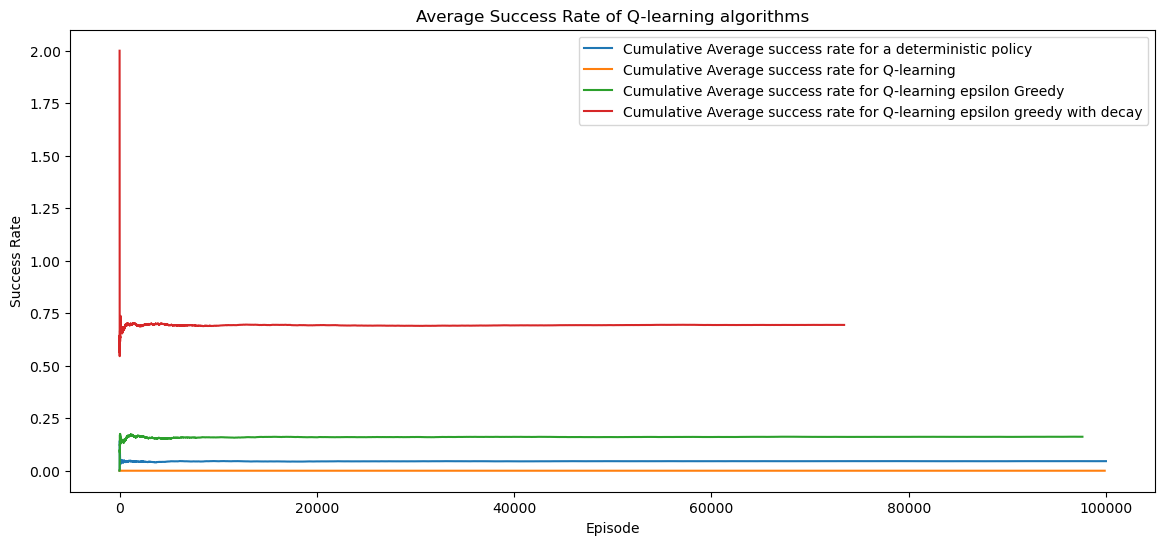

In [303]:
fig, axes = plt.subplots(figsize=(14, 6))
plt.plot(np.arange(len(rewards_d)), np.cumsum(rewards_d)/np.arange(len(rewards_d)), label="Cumulative Average success rate for a deterministic policy")
plt.plot(np.arange(len(rewards_q)), np.cumsum(rewards_q)/np.arange(len(rewards_q)), label="Cumulative Average success rate for Q-learning")
plt.plot(np.arange(len(rewards_q_greedy)), np.cumsum(rewards_q_greedy)/np.arange(len(rewards_q_greedy)), label="Cumulative Average success rate for Q-learning epsilon Greedy")
plt.plot(np.arange(len(rewards_q_greedy_decay)), np.cumsum(rewards_q_greedy_decay)/np.arange(len(rewards_q_greedy_decay)), label="Cumulative Average success rate for Q-learning epsilon greedy with decay")

axes.set(xlabel='Episode', ylabel='Success Rate', title='Average Success Rate of Q-learning algorithms')
plt.legend()
plt.show()

## 3. Conclusion :